# Data Science
# Exercise 3 (Part 2/3: Big Data Set)
<br/>se21m024
<br/>Thomas Stummer
<br/>Big Dataset: Census Income
<br/><br/>
*The interpretation of the data can be found in the document <b><i>se21m024_Stummer_ex3_Clustering.pdf</i><b>.
<br/><br/>
Data taken from:
<br/>https://archive.ics.uci.edu/ml/datasets/Census-Income+%28KDD%29
<br/><br/>
Data Original Owner:
<br/>U.S. Census Bureau
<br/>http://www.census.gov/
<br/>United States Department of Commerce
<br/><br/>
Donor:
<br/>Terran Lane and Ronny Kohavi
<br/>Data Mining and Visualization
<br/>Silicon Graphics.
<br/>terran '@' ecn.purdue.edu, ronnyk '@' sgi.com

# Import necessary dependencies

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np
import seaborn as sns
import math as math
import itertools as it
from sklearn.manifold import MDS
import sklearn.datasets as dt
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

pd.options.display.max_columns = None

%matplotlib inline

# Load dataset

In [20]:
columns = ['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour', 
'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 
'hispanic origin', 'sex', 'member', 'reason for unemployment', 'full or part time employment stat', 
'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat', 'region of previous residence', 
'state of previous residence', 'detailed household and family stat', 'detailed household summary in household',  
'instance weight', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 
'live in this house 1 year ago', 'migration prev res in sunbelt', 'num persons worked for employer', 'family members under 18', 
'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', 
'fill inc questionnaire for veterans admin', 'veterans benefits', 'weeks worked in year', 'year', '???']

raw_data = pd.read_csv('../Data Sets/Census-Income/census-income.data', sep=',', names = columns, skipinitialspace=True)

# re-shuffle records just to randomize data points
raw_data = raw_data.sample(frac=1, random_state=42).reset_index(drop=True)
#raw_data.head(5)

# Filter and transform features

In [21]:
# Examine only a subset of all attributes
numericalColumns = ['age', 'wage per hour', ]

categoryColumns = [
    'class of worker', 
    'education', 
    'race', 
    'hispanic origin', 
    'sex', 
    'year'
]

subset_attributes = numericalColumns + categoryColumns

# Assumption: The wage per hour is reprecented in Dollar Cents. For clearer interpretation it is converted to Dollars.
#print("Assumption: The wage per hour is reprecented in Dollar Cents. For clearer interpretation it is converted to Dollars.")
raw_data['wage per hour'] = raw_data['wage per hour'].apply(lambda value: value / 100)

# Fix wage per hour = 0
raw_data['wage per hour'] = raw_data['wage per hour'].apply(lambda value: None if value == 0 else value)

# Convert to categories
for column in categoryColumns:
    raw_data[column] = pd.factorize(raw_data[column])[0] + 1

data=raw_data[subset_attributes]
#data.head(5)

def parseFloatElementSafe(y):
    try:
        return float(y)
    except:
        return None

def parseFloat(x):
    return x.apply(lambda value: parseFloatElementSafe(value)) 

data = data.apply(parseFloat) 
data = data.dropna()
data_array = data.to_numpy()
#print("Number of data points: " + str(len(data_array)))
#print(data_array)


# Algorithm 1: MiniBatch KMeans


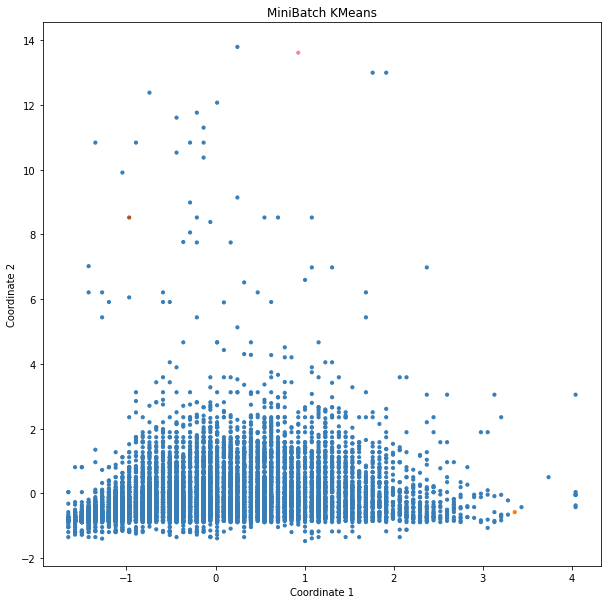

In [24]:
np.random.seed(0)

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 5,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

# update parameters with dataset-specific values
params = default_base.copy()

# Take only a subset of 1000 data points to make the result more compairable to the over algorithms
sample_size = 10000
data_array_subset = data_array[:sample_size,:]

X = data_array_subset

# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)

######### MiniBatch KMeans

#algorithm = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])

######### Average Linkage

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    X, n_neighbors=params["n_neighbors"], include_self=False
)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

algorithm = cluster.AgglomerativeClustering(
    linkage="average",
    affinity="cityblock",
    n_clusters=params["n_clusters"],
    connectivity=connectivity    
)

######### DBSCAN

#algorithm = cluster.DBSCAN(eps=params["eps"])

#########

algorithm.fit(X)

if hasattr(algorithm, "labels_"):
    y_pred = algorithm.labels_.astype(int)
else:
    y_pred = algorithm.predict(X)

colors = np.array(
    list(
        islice(
            cycle(
                [
                    "#377eb8",
                    "#ff7f00",
                    "#4daf4a",
                    "#f781bf",
                    "#a65628",
                    "#984ea3",
                    "#999999",
                    "#e41a1c",
                    "#dede00",
                ]
            ),
            int(max(y_pred) + 1),
        )
    )
)
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])

fig = plt.figure(2, (10,10))
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
plt.title('MiniBatch KMeans')
plt.xlabel("Coordinate 1")
plt.ylabel("Coordinate 2")
plt.show()


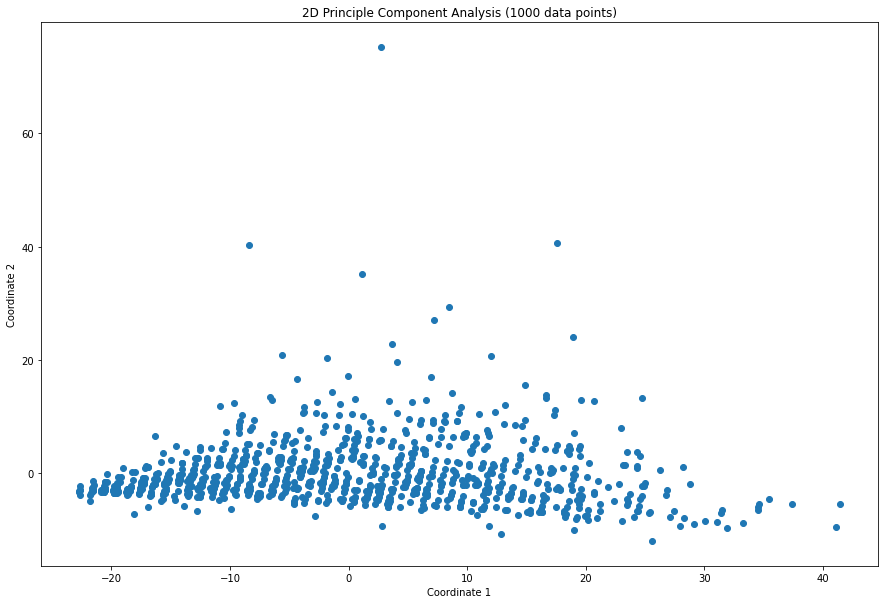

The principle component 1 accounts for 76.9% of the variance in the data set, whereas principle component 2 accounts for 16.3% of the variance. This sums up to 93.2%.


In [59]:
# Take only a subset of 1000 data points to make the result more compairable to the over algorithms
sample_size = 1000
data_array_subset = data_array[:sample_size,:]

pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_array_subset)
principal_df = pd.DataFrame(data = principal_components)
principle_array = principal_df.to_numpy()

fig = plt.figure(2, (15,10))
plt.scatter(principle_array[:,0], principle_array[:,1])
plt.title('2D Principle Component Analysis (' + str(sample_size) + ' data points)')
plt.xlabel("Coordinate 1")
plt.ylabel("Coordinate 2")
plt.show()

pc_1_variance = round(pca.explained_variance_ratio_[0] * 100, 1)
pc_2_variance = round(pca.explained_variance_ratio_[1] * 100, 1)

print("The principle component 1 accounts for " + str(pc_1_variance) + "% of the variance in the data set, whereas principle component 2 accounts for " + str(pc_2_variance) + "% of the variance. This sums up to " + str(pc_1_variance + pc_2_variance) + "%.")

# Algorithm 2: Agglomerative Clustering (average linkage)


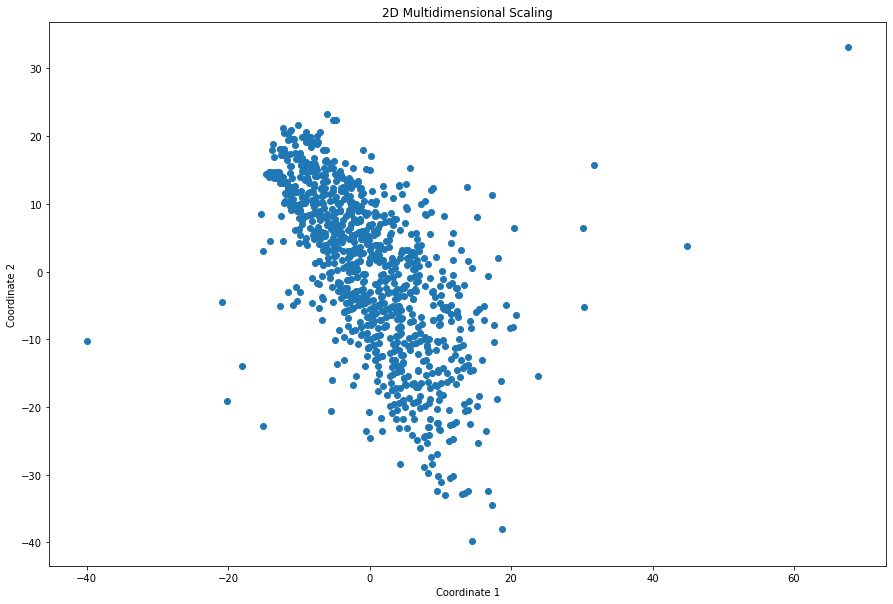

In [58]:
# Take only a subset of 1000 data points because otherwise the computation does not finish in time
sample_size = 1000
data_array_subset = data_array[:sample_size,:]

mds = MDS(random_state=0)
principal_components = mds.fit_transform(data_array_subset)
principal_df = pd.DataFrame(data = principal_components)
principle_array = principal_df.to_numpy()

fig = plt.figure(2, (15,10))
plt.scatter(principle_array[:,0], principle_array[:,1])
plt.title('2D Multidimensional Scaling (' + str(sample_size) + ' data points)')
plt.xlabel("Coordinate 1")
plt.ylabel("Coordinate 2")
plt.show()

# Algorithm 3: DBSCAN


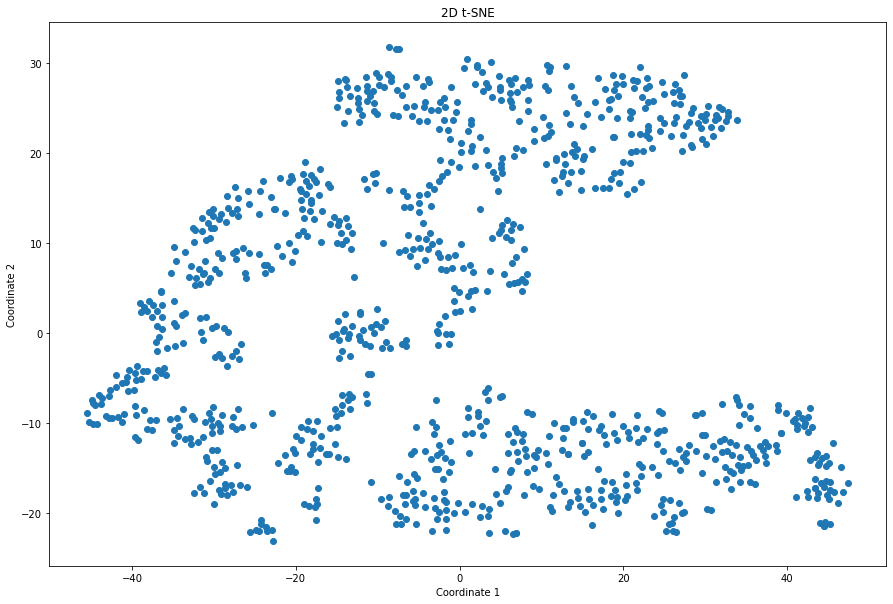

In [55]:
# Take only a subset of 1000 data points because otherwise the computation does not finish in time
sample_size = 1000
data_array_subset = data_array[:sample_size,:]

tsne = TSNE(n_components=2, random_state=123)
principal_components = tsne.fit_transform(data_array_subset)
principal_df = pd.DataFrame(data = principal_components)
principle_array = principal_df.to_numpy()

fig = plt.figure(2, (15,10))
plt.scatter(principle_array[:,0], principle_array[:,1])
plt.title('2D t-SNE (' + str(sample_size) + ' data points)')
plt.xlabel("Coordinate 1")
plt.ylabel("Coordinate 2")
plt.show()